# Introduction to DeepLearning for Computer Vision

Earliest and biggest success story of deep learning. These modesl are also at the heart of cutting-edge research in autonomous driving, robotics, AI-assisted medical diagnosis, autonomous retail checkout systems, and autonomous farming.
Computer vision is the problem domain that led to the initial rise of deep learning. A type of deep learning called convolutional neural networks started getting good results on image classification competitions around that time.
This chapter introduces convolutional neural networks, convnets, type of deep learning model used almost universally in CV applications.

## Introduction to Convnets


In [1]:
#Instantiating a small convnet

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(28,28,1))
x = layers.Conv2D(filters=32,kernel_size=3,activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10,activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Convnet takes as input tensors of shape (img_height, img_width, img_channels), not including the batch dimension. In this case, we'll configure the convnet to process inputs of size (28,28,1) which is the format of MNIST images.

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

You can see that the output of every Conv2D and MaxPooling2D layer is a rank-3 tensor of shape (height, width, channels). Width and height dimensions tend to shrink as you go deeper in the model. the number of channels is controlled by the first argument passed to the Conv2D layers (32,64 or 128).
After the last Conv2D layer, we end up with an output of shape (3,3,128), a 3x3 feature map of 128 channels. The next step is to feed this output into a densely connected classifier. These classifiers process vectors, which are 1D, whereas the current output is a rank-3 tensor.
To bridge this gap, we flatten the 3D outputs to 1D with a Flatten layer before adding the Dense layers.
Finally, we do 10-way classification, so out last layer has 10 outputs and a softmax activation.
Let's train the convnet on the MNIST digits, because we are doing a 10-way classification with a softmax output, we use a categorical crossentropy loss, and because out labels are integers, we use sparse version. (sparse_categorical_crossentropy).

In [5]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000,28,28,1))
train_images = train_images.astype('float32') /255
test_images = test_images.reshape((10000,28,28,1))
test_images = test_images.astype('float32') /255
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images,train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 29s 9ms/step - loss: 0.1512 - accuracy: 0.9533
Epoch 2/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0449 - accuracy: 0.9857
Epoch 3/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0316 - accuracy: 0.9902
Epoch 4/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0241 - accuracy: 0.9927
Epoch 5/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0188 - accuracy: 0.9942


In [6]:
test_loss, test_acc = model.evaluate(test_images,test_labels)
print(f'Test accuracy: {test_acc:.3f}')

313/313 [==============================] - 2s 5ms/step - loss: 0.0262 - accuracy: 0.9917
Test accuracy: 0.992


### The convolution Operation
The fundamental difference between a densely connected layer and a convolutional layer is this:
Dense layers learn global patterns in their input feature space, wherease convolution layers learn local patterns.\
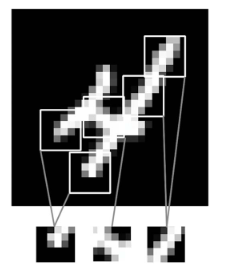

This key characteristic gives convnets two interesting properties:
* The pattern they learn are translational-invariant. After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere. A densely connected model would have to learn the pattern anew if it appeared at a new location. This makes convnets data-efficient when processing images: they need fewer training samples to learn representations that have generalization power.
* They can learn spatial hierarchies of patterns. A first convolution layer will learn small local patterns such as edges, a second convolution layer will learn larger patterns made of the features of the first layers, and so on. This allows convnets to efficiently learn increasingly complex and abstract visual concepts, because the visual world is fundamentally spatially hierarchical.\
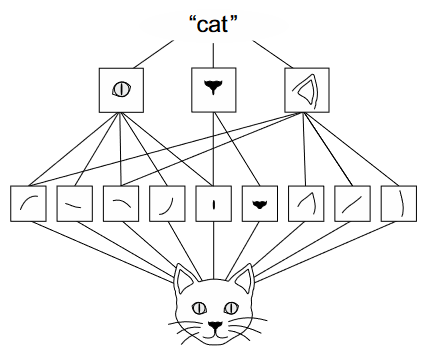

Convolutions operate over rank-3 tensors called feature maps, with two spatial axes (height and width) as well as a depth axis (channel). For an RGB image, the dimension of the channel is 3, because the image has 3 color channels: red, green and blue. For a black and white, the depth is 1 (levels of gray).
convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an output feature map. \
This map is still rank-3 tensor, its depth can be arbitrary, because the output depth is a parameter of the layer and the channels in the depth axis no longer stand for specific colors, they stand for filters. \
Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept "Presence of a face in the input".
In the MNIST example the first convolution layer takes a feature map of size (28,28,1) and outputs a feature map of size (26,26,32): computes 32 filters over its input.
Each of these 32 output channels contains 26x26 grid of values, a response map of the filter over the input, indicating the response of that filter pattern at different locations in the input.\
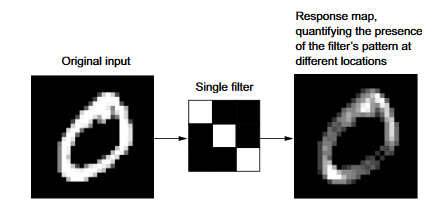

That is what the term feature map means: every dimension in the depth axis is a feature (or filter), and the rank-2 tensor output[:,:,n] is the 2D spatial map of the response of this filter over the input.
Convolutions are diefined by two key parameters:
* Size of the patches extracted from the inputs-typically 3x3 or 5x5. In the example, they were 3x3, which is common choice.
* Depth of the output feature map -  This is the number of filters computed by the convoluton. The example started with a depth of 32 and ended with a depth of 64.

In Keras Conv2D layers, these params are the first arguments passed to the layer.
Convolution works bby sliding these windows of size 3x3 or 5x5 over 3D input feature map, stopping at every possible location, and extracting the 3D pathc of surrounding features. Each patch is then transformed into a 1D vector of shape (output_depth,) which is done via tensor product with a learned weight matrix, called convolutional kernel- the same kernel used across every patch.\
All these vecotrs are then spatially reassembled into a 3D output map of shape (height,width, output_depth). Every spatial location in the output feature map corresponds to the same location in the input feature map. For instance, with 3x3 windows the vector output[i,j,:] comes from 3D patch input[i.1:i+1,j-1:j+1,:].
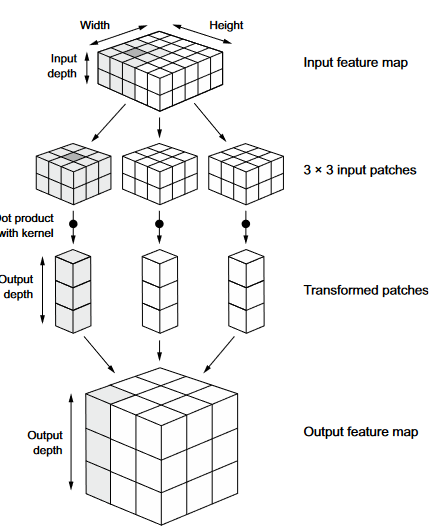

Note that the output width and height may differ from the input width and height for two reasons:
* border effects, which can be countered by padding the input feature map
* the use of strides.

#### Understanding Border Effects and padding

Consider a 5x5 feature map. there are only 9 tiles around which you can center a 3x3 window, forming a 3x3 grid. Hence, the output feature map will be 3x3. It shrinks a little: by exactly two tiles alongside each dimension, in this case. If you want to get an output feature map with the same spatial dimensions as the input you can use padding.\
Padding adds an appropriate number of rows and columns on each side of the input feature map so as to make it possible to fit center convolution windows around every input tile. For a 3x3 window, you add one column on the right, one on the left and one on top and one at the bottom.
For a 5x5:
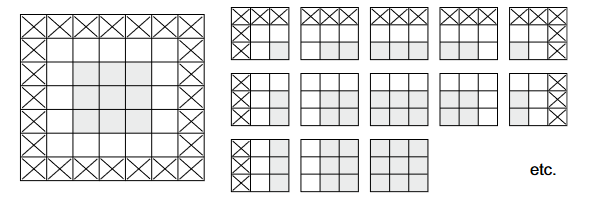

In Conv2D layers, padding is configurable via the padding argument, which takes two values: 'valid', no padding, and 'same', pad in such a way as to have an output with the same width and height as the input. Padding argument defaults to valid.

#### Understanding convolution strides

The other factor that can influence output size is the notion of strides. The distance between two successive windows is a parameter of the convolution called stride, which defaults to 1. It is possible to have strided convolutions: convolutions with a stride higher than 1. \
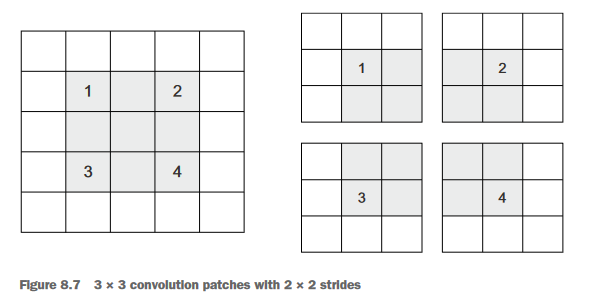 \
Using stride 2 means width and height of the feature map are downsampled by a factor of 2. Strided convolutions are rarely used in classification models, but they come in handy for some types of models.
In classification models instead of strides we tend to use max-pooling operation to downsample feature maps.

### Max-pooling operation
The role of max-pooling is to aggresively downsample feature maps. Max-pooling consists of extracting windows from the input feature maps and outputting the max value of each channel. It is conceptually similar to convolution except that instead of transforming local patches via a learned linear transformation, they are transformed via a hardcoded max tensor operation.
Max pooling is usually done with 2x2 windows and stride 2, while convolution is typically done with 3x3 windows and no stride.

In [7]:
#Incorrectly structured convnet

inputs = keras.Input(shape=(28,28,1))
x=layers.Conv2D(filters=32,kernel_size=3, activation='relu')(inputs)
x=layers.Conv2D(filters=64,kernel_size=3, activation='relu')(x)
x=layers.Conv2D(filters=128,kernel_size=3, activation='relu')(x)
x=layers.Flatten()(x)
outputs = layers.Dense(10,activation='softmax')(x)
model_no_max_pool = keras.Model(inputs,outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

What's wrong?
* It is not conducive to learning a spatial hierarcgy of features. The 3x3 windows in the third layerwill only contain info coming from 7x7 windows in the initial input. The high-level patterns learned by the convnet will still be very small, which may not be enough  to learn to classify digits.
* The final feature map has 22x22x128 = 61,952 total coefficients per sample. This is huge. When flattening to stick a Dense layer of size 10 on top, that layer would have over half a million parameters.
In short, the reason to use downsampling is to reduce the number of feature-map coefficients to process, as well as to induce spatial-filter hierarchies by making successive convolution layers look at increasingly large windows. \
Max pooling is not the only way to achieve such downsampling. You can use strides and use average pooling. But, max pooling tends to work better than spatial presence of some pattern or concept over the different tiles of the feature map, and it's more informative to look at the maximal presence of different features than their average presence. \ 
The most reasonable strategy is to first produce dense maps of features and then look at the maximal activation of the features over small patches, rather than looking at sparser windows of the inputs or averaging input patches.

## Training a convnet from scratch on a small dataset

Training an image-classification model using very little data is common. A few samples can mean anywhere from a few hundred to a few tens of thousands of images. 
In this section, we review one basic strategy to tackle this problem: training a new model from scratch usign what little data you have. We review two more essential techniques for applying deep learning to small datasets: feature extraction with a pretrained model and fine-tuning a pretrained model.
With data augmentation, these strategies trainin a small model from scratch, doing feature extraction using a pretrained model, and fine-tuning a pretrained model is the future toolbox for tackling the problem of perfoming image classification with small datasets.

### The relevance of deep learning for small-data problems
What qualifies as enough samples to train a model is relative - relative to the size and depth of the model you are trying to train,for starters. It is not possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundred can potentially suffice if the model is small and well regularized and the task is simple. Because convnets learn local, translation-invariant features, they're highly data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will yield reasonable results despite a relative lack of data, without the need for any custom feature engineering.
What's more, deep Learning models are by nature highly repurposable: you can tak, say, an image-classification or speech-to-text model trained on a large-scale dataset annd reuse it on a significantly differ problem with only minor changes. Specifically, in the case of CV, many pretrained models are publicly available for download and can be used to bootstrap powerful vision models out of little data.

### Download the data

We are going to use a Dogs vs Cats dataset, which was made available in kaggle for a competition. You can either download it from www.kaggle.com/c/dogs-vs-cats/data or by using the Kaggle API.\
Pictures are medium-resolution color JPEGs. The original competition was won by using convnets. The best achieved up to 95% accuracy.\
This dataset contains 25,000 images of dogs and cats. After download we create a new dataset containing three subsets: train set with 1,000 samples of each class, validation set with 500 for each class and test set with 1,000 of each class. This is becusae many of the image datasets you will encounter only contain a few thousand samples.

In [2]:
!kaggle competitions download -c dogs-vs-cats


  0%|          | 0.00/812M [00:00<?, ?B/s]
  0%|          | 1.00M/812M [00:00<04:48, 2.95MB/s]
  0%|          | 2.00M/812M [00:00<03:42, 3.82MB/s]
  0%|          | 3.00M/812M [00:00<03:28, 4.07MB/s]
  0%|          | 4.00M/812M [00:01<03:27, 4.09MB/s]
  1%|          | 5.00M/812M [00:01<03:12, 4.39MB/s]
  1%|          | 6.00M/812M [00:01<02:58, 4.73MB/s]
  1%|          | 7.00M/812M [00:01<03:01, 4.66MB/s]
  1%|          | 8.00M/812M [00:01<03:03, 4.59MB/s]
  1%|          | 9.00M/812M [00:02<02:58, 4.73MB/s]
  1%|          | 10.0M/812M [00:02<02:50, 4.95MB/s]
  1%|▏         | 11.0M/812M [00:02<02:46, 5.03MB/s]
  1%|▏         | 12.0M/812M [00:02<02:53, 4.85MB/s]
  2%|▏         | 13.0M/812M [00:02<02:53, 4.83MB/s]
  2%|▏         | 14.0M/812M [00:03<02:54, 4.80MB/s]
  2%|▏         | 15.0M/812M [00:03<02:55, 4.75MB/s]
  2%|▏         | 16.0M/812M [00:03<02:52, 4.84MB/s]
  2%|▏         | 17.0M/812M [00:03<02:55, 4.75MB/s]
  2%|▏         | 18.0M/812M [00:04<03:02, 4.57MB/s]
  2%|▏         | 19.

In [3]:
import os, shutil, pathlib

original_dir = pathlib.Path('./dogs-vs-cats/train')
new_base_dir = pathlib.Path('./dogs-vs-cats/cats_vs_dogs_small')

In [4]:

def make_subset(subset_name, start_index, end_index):
    for category in ('cat','dog'):
        dir = new_base_dir /subset_name / category
        os.makedirs(dir)
        fnames = [f'{category}.{i}.jpg' for i in range(start_index,end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir /fname, dst=dir/fname)
make_subset('train', start_index=0, end_index=1000)
make_subset('val', start_index=1000, end_index=1500)
make_subset('test', start_index=1500, end_index=2000)

We now have 2000 training images, 1000 val images and 2000 test images. \
Each split contains the same number of samples from each class: this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success.

### Building the model
We will reuse the same general model of the previous example: convnet which is a stack of alternated Conv2D and MaxPooling2D layers. \
Because we are dealing with bigger images and more complex problem, we make out model larger: two more Conv"d and MaxPooling2D. This serves both to augment capacity of the model and to further reduce the size of the featuer maps so they are not overly large when reach the Flatten layer.
Because we start from inputs of size 180x180, we end up with feature maps of size 7x7 just before the Flatten.

Note: Depth of the feature maps progressively increases, where the size of the feature maps decreases.

Because we have a binary-classification pproblem, we end the model with a single unit and sigmoid activation. This will encode the probability that the model is looking at one class or the other.
We also add a Rescaling layer which will rescale image inputs to the [0,1] range.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180,180,3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32,kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

For compilation,we go with the RMSprop optimizer. Because we ended the model with a single sigmoid unit, we use binary crossentropy as the loss.

In [7]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

### Data Preprocessing
Data should be formatted into appropriately preprocessed floating-point tensors before being fed into the model. Currently the data sits on a drive a jpeg, so the steps for getting it into the model are:

1. Read the picture files.
2. Decode the JPEG content to RGB grids of pixels.
3. Convert these into floating-point tensors.
4. Resize them to a shared size (180x180)
5. Pack them into batches (32 images)

Keras fortunately jas utilities to take care of these steps automatically. It features the function image_dataset_from_directory(), which let us quickly set up a data pipeline that can automatically turn image files into batches of preprocessed tensors.
Calling image_dataset_from_directory(directory) will first list the subdirectories of directory and assume each one contains images from one of our classes. It will then indes the image files in each subdirectory. Finally, it will create and return a tf.data.Dataset object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size and pack them into batches.

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(new_base_dir/'train', image_size=(180,180), batch_size=32)
val_dataset = image_dataset_from_directory(new_base_dir/'val', image_size=(180,180),batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / 'test', image_size=(180,180),batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [9]:
#Displaying the shapes of the data and labels yielded by the Dataset

for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('lables batch shape:', labels_batch.shape)
    break


data batch shape: (32, 180, 180, 3)
lables batch shape: (32,)


Let's fit the model, we use the validation data argument to monitor validation metrics on a separate Dataset object.
We also use a ModelCheckpoint callback to save the model after each epoch. We configure it eith the path specifying where to save the file, as well as the arguments save_best_only = True and monitor='val_loss': they tell the callback to only same a new file when the current value of the val_loss is lower than any previous time during training.

In [10]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath='convnet_from_scratch.keras', save_best_only=True,monitor='val_loss')]

history = model.fit(train_dataset,epochs=30,validation_data=val_dataset, callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 30s 122ms/step - loss: 0.7924 - accuracy: 0.5050 - val_loss: 0.7579 - val_accuracy: 0.5000
Epoch 2/30
63/63 [==============================] - 5s 76ms/step - loss: 0.6944 - accuracy: 0.5355 - val_loss: 0.6772 - val_accuracy: 0.6380
Epoch 3/30
63/63 [==============================] - 5s 74ms/step - loss: 0.7017 - accuracy: 0.5675 - val_loss: 0.6496 - val_accuracy: 0.5960
Epoch 4/30
63/63 [==============================] - 5s 75ms/step - loss: 0.6598 - accuracy: 0.6510 - val_loss: 0.6198 - val_accuracy: 0.6320
Epoch 5/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6101 - accuracy: 0.6725 - val_loss: 0.7014 - val_accuracy: 0.6340
Epoch 6/30
63/63 [==============================] - 5s 73ms/step - loss: 0.5921 - accuracy: 0.6945 - val_loss: 0.6854 - val_accuracy: 0.6160
Epoch 7/30
63/63 [==============================] - 5s 74ms/step - loss: 0.5341 - accuracy: 0.7325 - val_loss: 0.5594 - val_accuracy: 0.7160
Epoch 8/30


Plot the loss and accuracy of the model

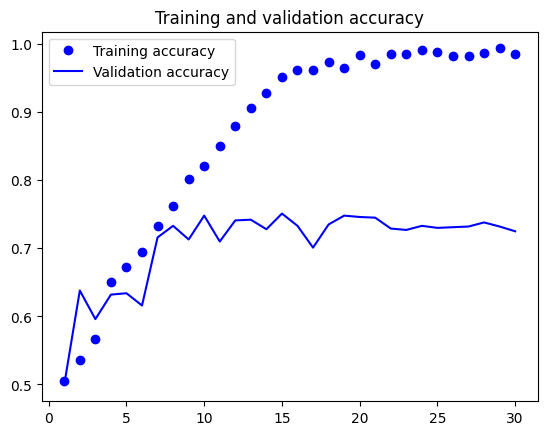

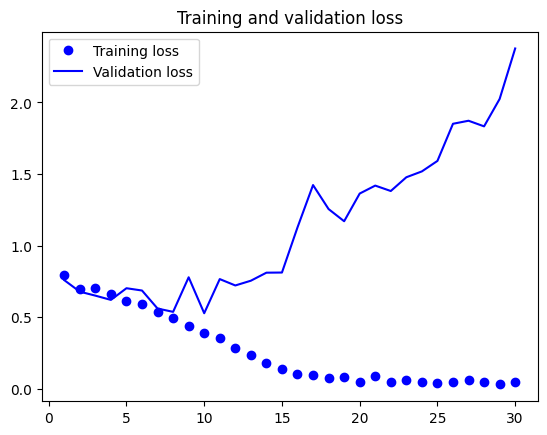

In [11]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss= history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,'bo',label='Training accuracy')
plt.plot(epochs, val_accuracy,'b',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


These are characteristic of overfitting. Training accuracy increases linearly over time, until it reaches 100%, whereas the validation accuracy peaks at 75%. The validation loss keeps decreasign linearly as training proceeds.

In [12]:
test_model = keras.models.load_model('convnet_from_scratch.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.3f}')

32/32 [==============================] - 2s 35ms/step - loss: 0.6318 - accuracy: 0.7190
Test accuracy: 0.719


We get an accuracy of 72%. Because we have few training samples, overfitting will be our number one concern.

### Use Data augmentation
Overfitting is caused by having too few samples to learn from, rendering you unable to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit.
Data augmentation takes the approach of generating more training data from existing samples by augmenting the samplesvia a number of random transformations that yield believable-looking images. The foal is that the model will never see the exact same picture twice.
In Keras, it can be done by adding a number of data augmentation layers at the start of the model.

In [13]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

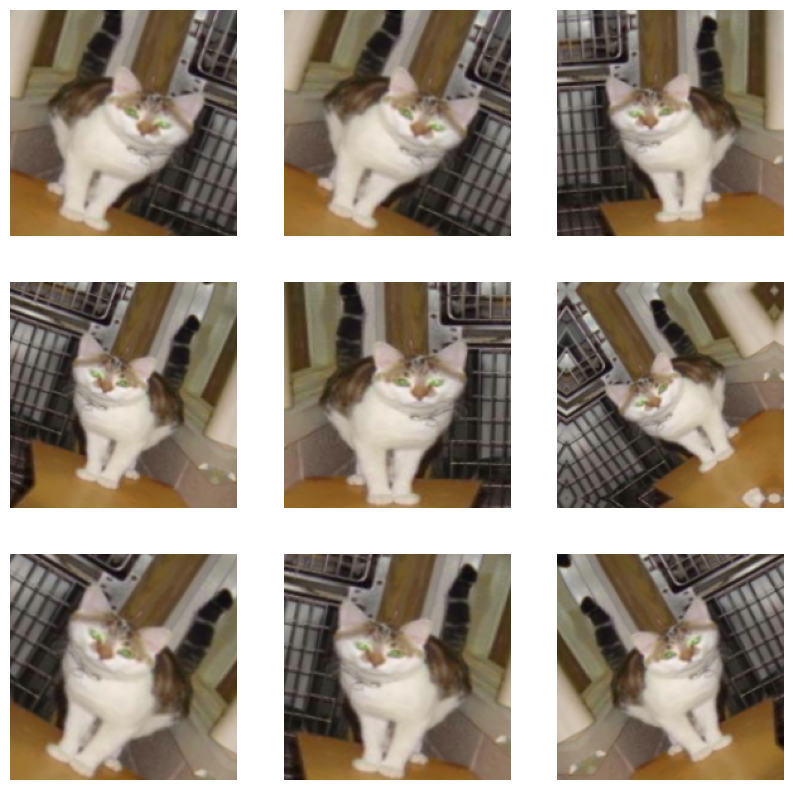

In [14]:
#Let's look at the augmented images
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

We can't produce new information but we can remix existing one. this may not be enough to get rid of overfitting. To further fight it, we'll also add a Dropout layer.
One last thing about random image augmentation layers: just like dropout, they are inactive during inference. during evaluation, our model will behave like it did when there was no augmentation and dropout

In [15]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32,kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(train_dataset,epochs=100,validation_data=val_dataset,callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 37s 515ms/step - loss: 0.7113 - accuracy: 0.5070 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 32s 511ms/step - loss: 0.7117 - accuracy: 0.5310 - val_loss: 0.6792 - val_accuracy: 0.5950
Epoch 3/100
63/63 [==============================] - 33s 522ms/step - loss: 0.6903 - accuracy: 0.5760 - val_loss: 0.6684 - val_accuracy: 0.6130
Epoch 4/100
63/63 [==============================] - 32s 501ms/step - loss: 0.6636 - accuracy: 0.6130 - val_loss: 0.6603 - val_accuracy: 0.5950
Epoch 5/100
63/63 [==============================] - 31s 494ms/step - loss: 0.6578 - accuracy: 0.6225 - val_loss: 0.6386 - val_accuracy: 0.6430
Epoch 6/100
63/63 [==============================] - 31s 487ms/step - loss: 0.6396 - accuracy: 0.6565 - val_loss: 0.6336 - val_accuracy: 0.6290
Epoch 7/100
63/63 [==============================] - 31s 488ms/step - loss: 0.6271 - accuracy: 0.6630 - val_loss: 0.6309 - val_accuracy:

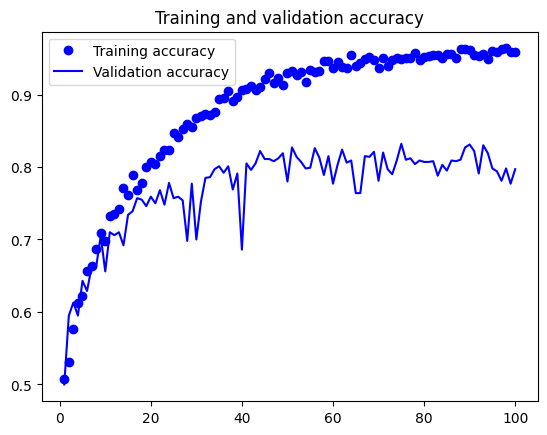

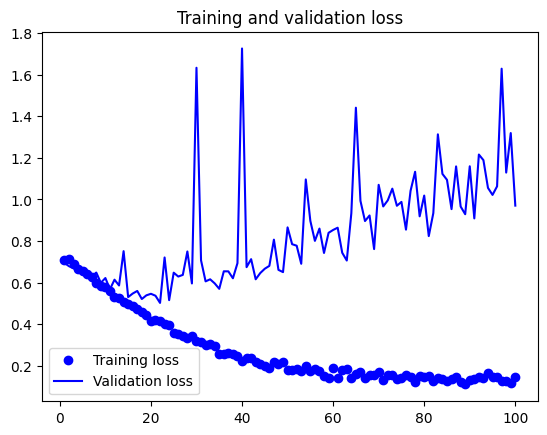

In [17]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss= history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,'bo',label='Training accuracy')
plt.plot(epochs, val_accuracy,'b',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [18]:
test_model = keras.models.load_model('convnet_from_scratch_with_augmentation.keras')
test_loss,test_acc = test_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.3f}')

32/32 [==============================] - 1s 26ms/step - loss: 0.5274 - accuracy: 0.7560
Test accuracy: 0.756


## Leveraging a pretrained model
A common and highly effective approach to deep learning on datasets is to use a pretrained model. A pretrained model is a model previously trained on large datasets, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, the spatial hierarchy of features learnd by the model can effectively act as a generic model of the visual world, and its features can prove useful for many different CV problems, eve if these new problems may involve different classes than those of the original task. You might train a model on ImageNet(where classes are mostly animals and everyday objects) and then reporpuse it for somethins like identifying furniture objects. such portability is a key advantage of deep learning.\
In this case, let us consider a large convnet trained on ImageNet dataset. We use VGG16 architecture.
There are two ways to use a pretrained model: feature extraction and fine-tuning.

### Feature extraction with a pretrained model
Feature extraction consists of using therepresentations learned by a previously trained model to extract interesting features from new samples. These features are then run through a new classifier trained from scratch.
Convnets used for image classification comprise two parts: Start with a series of ppoling and convolution layers, and end with a densely connected classifier. The first part is called the convolutional base, in case of convnets, the feature extraction part consists of taking the convolutional base of a pre-trained network, running the new data through it and training a new classifier on top of the output.
The reason we do this is because the representations learned by the convolutional base are likely yo be more generic and more reusable: feature maps of a convnet are presence maps of generic concepts over a picture, wich are likely to be useful regardless of the CV problem.\
But, the representation learned by the classifier will need to be specific to the set of classes on which the model was trained. Additionally, representations found in densely connected layers no longer contain any info abouth where objects are located in the input image. For problems where object location matters, densely connected features are useless.

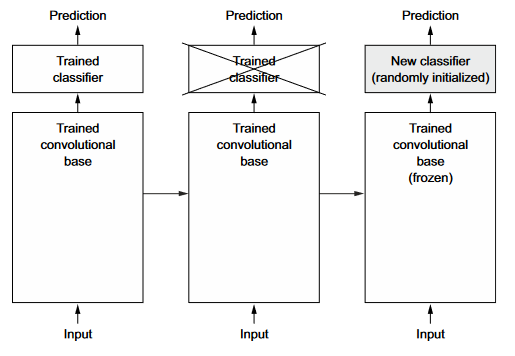\

The level of generality of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that ome earlier extract local , highly generic feature maps, whereas layers higher up extract more-abstract concepts. So if the new dataset differs a lot from the dataset the original model was trained, you may be better off using only the first few layers of the model.
The VGG16 model, among others, comes with Keras. You can import it from keras.applications.

In [7]:
conv_base=keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(180,180,3))

We pass 3 arguments:

* weights - specifies the weight checkpoint from which to initialize the model
* include_top - refers to including the densely connected classifier on top of the network.
* input_shape - shape of the image tensors we'll feed to the network.

In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

The final feature map has shape (5,5,512). That's the feature map on top of which we'll stick a densely connected classifier.
At this point there are two ways we can proceed:

* Run convolutional base over our dataser, record its output to a Numpy array and then use it as input to a standalone, densely connected classifier. This is a fast and cheap to run solution, because only requires running convolutional base once for every input image. But we can't use data augmentation.

* Extend the model we have (conv_base) by adding Dense layers on top, and run the whole thing on the input data. This allow us to use data augmentation, because every input image goes through the convolutional base every time. But this is more expensive.


#### Fast feature extraction without data augmentation

We start by extracting features as numpy arrays by calling predict() method of the conv_base model on our training, validation and testing datasets.

In [10]:
import numpy as np
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images,labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(val_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)
print(f'Train Features shape: {train_features.shape}')

1/1 [==============================] - 0s 25ms/step
Train Features shape: (2000, 5, 5, 512)


predict() only expects images, not labels, but our current dataset yields batches that contain both images and their labels. Moreover, the vgg16 model expects inputs that are preprocessed with the function keras.applications.vgg16.preprocess_input, which scales pixel values to an appropriate range.

At this point we can define our densely connected classifier and train it on the data and labels that we just recorded.

In [11]:
inputs = keras.Input(shape=(5,5,512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs,outputs)
model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint(filepath='feature_extraction.keras',save_best_only=True,monitor='val_loss')]
history = model.fit(train_features,train_labels,epochs=20,validation_data=(val_features,val_labels),callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 2s 15ms/step - loss: 14.8148 - accuracy: 0.9260 - val_loss: 2.2248 - val_accuracy: 0.9760
Epoch 2/20
63/63 [==============================] - 1s 10ms/step - loss: 4.7629 - accuracy: 0.9645 - val_loss: 6.5059 - val_accuracy: 0.9640
Epoch 3/20
63/63 [==============================] - 1s 10ms/step - loss: 1.5065 - accuracy: 0.9870 - val_loss: 5.0505 - val_accuracy: 0.9700
Epoch 4/20
63/63 [==============================] - 1s 10ms/step - loss: 1.7761 - accuracy: 0.9870 - val_loss: 3.6412 - val_accuracy: 0.9780
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1.0120 - accuracy: 0.9930 - val_loss: 3.8059 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 1s 10ms/step - loss: 1.5236 - accuracy: 0.9905 - val_loss: 4.8886 - val_accuracy: 0.9740
Epoch 7/20
63/63 [==============================] - 1s 10ms/step - loss: 0.3518 - accuracy: 0.9970 - val_loss: 4.3594 - val_accuracy: 0.9750
Epoch 8/20
6

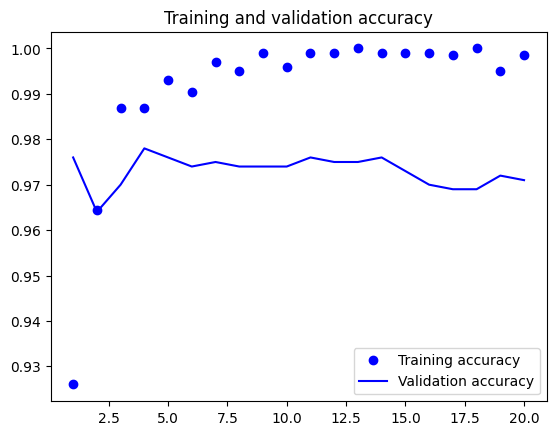

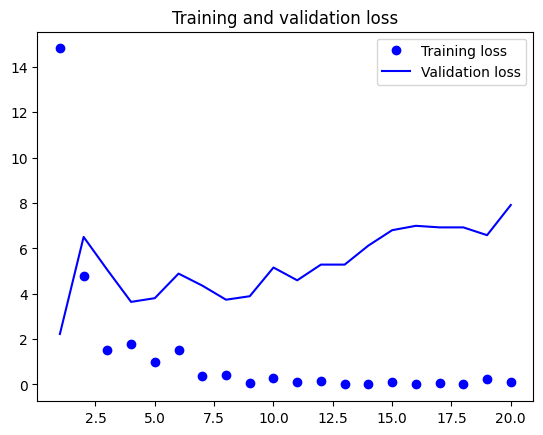

In [12]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss= history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,'bo',label='Training accuracy')
plt.plot(epochs, val_accuracy,'b',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


We reach a validation accuracy of about 97%-much better than before. This is a bit of an unfair comparison, however, because imagenet contains many dog and cat instances, which means, our pretrained model already has the exact knowledge required for he task at hand. This won't always be the case when you use pretrained features.
However, the plots also indicate that we are overfitting, almost from the start despite using dropout. This is because this technique does not use data augmentation.

#### Feature extraction together with data augmentation
Let's review the second technique, which is more slower and expansive, but allows to use data augmentation during training: creating a model that chains the conv_base with a new dense classifier, and training it end to end.
To do this, we will first freeze the convolutional base. Freezing a layer or set of layers means preventing their weights from being updated during training. If we don't do this, the representation that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, destroying the representations previously learned.
In Keras we freeze the layer or model by setting trainable to False.

In [13]:
conv_base = keras.applications.vgg16.VGG16(weights='imagenet',include_top=False)
conv_base.trainable=False

setting trainable to False empties the list of trainable weights of the layer or model.

In [14]:
conv_base.trainable=True
print('This is the number of trainable weights before freezing the conv base:', len(conv_base.trainable_weights))
conv_base.trainable=False
print('This is the number of trainable weights after freezing the conv base:', len(conv_base.trainable_weights))


This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


Now we can create a new model that chains together
1. data augmentation stage
2. Our frozen convolutional base
3. A dense classifier

In [15]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs,outputs)
model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

with this setup, only the weights from the Dense layers will be trained. That's a total of four weight tensors: two per layer. Note that for these changes to take effect, you must first compile the model. If you modify the model or weight trainability, you have to recompile it.

In [16]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath='feature_extraction_with_data_augmentation.keras',save_best_only=True,monitor='val_loss')]
history = model.fit(train_dataset,epochs=50,validation_data=val_dataset,callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 42s 604ms/step - loss: 20.4899 - accuracy: 0.8915 - val_loss: 12.3728 - val_accuracy: 0.9290
Epoch 2/50
63/63 [==============================] - 39s 624ms/step - loss: 7.6858 - accuracy: 0.9415 - val_loss: 3.8363 - val_accuracy: 0.9670
Epoch 3/50
63/63 [==============================] - 37s 579ms/step - loss: 4.0748 - accuracy: 0.9625 - val_loss: 8.4048 - val_accuracy: 0.9600
Epoch 4/50
63/63 [==============================] - 39s 613ms/step - loss: 5.2122 - accuracy: 0.9610 - val_loss: 5.6387 - val_accuracy: 0.9670
Epoch 5/50
63/63 [==============================] - 41s 651ms/step - loss: 3.5018 - accuracy: 0.9675 - val_loss: 4.6856 - val_accuracy: 0.9690
Epoch 6/50
63/63 [==============================] - 41s 652ms/step - loss: 2.5264 - accuracy: 0.9780 - val_loss: 3.9766 - val_accuracy: 0.9730
Epoch 7/50
63/63 [==============================] - 41s 653ms/step - loss: 2.2939 - accuracy: 0.9830 - val_loss: 3.9130 - val_accuracy: 0.97

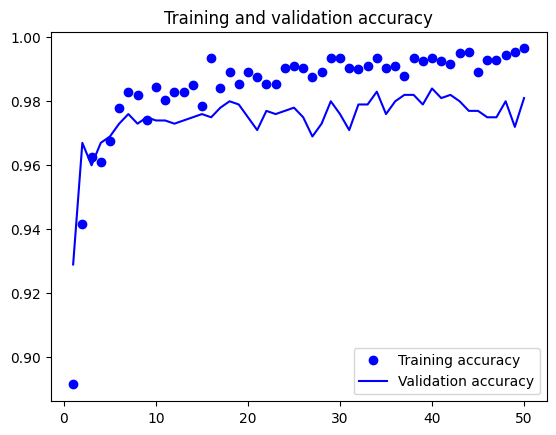

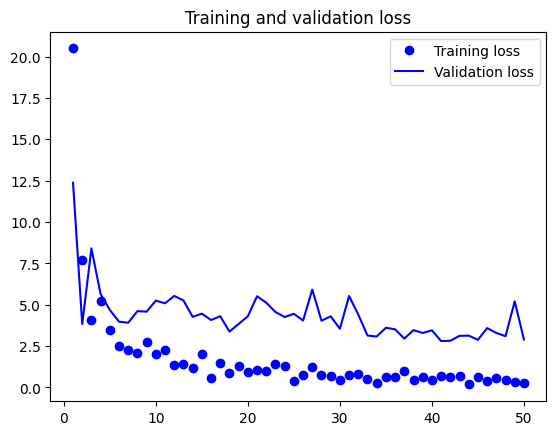

In [17]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss= history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,'bo',label='Training accuracy')
plt.plot(epochs, val_accuracy,'b',label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [18]:
test_model = keras.models.load_model('feature_extraction_with_data_augmentation.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.3f}')

32/32 [==============================] - 5s 136ms/step - loss: 3.5216 - accuracy: 0.9780
Test accuracy: 0.978


We get a test accuracy of 97.8%. This is only a modest improvement compared to the previous test accuracy, which is a bit disappointing given the strong results on the validation data. A model's accuracy always depends on the set of samples you evaluate it on!

### Fine-Tuning a pretrained model
Another used technique for model reuse is fine-tuning. Fine-tuning consists of unfreezing a few of the rop layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model and these top layers. This is called fine-tuning because it slightly adjust the more abstract representations of the model being reused in order to make them more relevant for the problem at hand.
The steps for fine-tuninig a network are:
1. Add out custom network on top of an already-trained based network
2. Freeze the base network
3. Train the part we added
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part we added.
We'll fine tune the last three conv layers.
Why not fine-tune more layers?
You could but you need to consider:
* Earlier layers in the conv base encode more generic, reusable features, whereas layers higher up encode more specialized features. It's more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on your new problem. There would be fast-decreasing returns in fine-tuning lower layers.
* The more parameters you are training, the more you are at risk of overfitting. The conv base has 15 million params, so it would be risky to attempt to train it on your small dataset.

In [19]:
conv_base.trainable=True
for layer in conv_base.layers[:-4]:
    layer.trainable=False

Now we fine tune, we do this with the RMSprop optimizer, using a very low learning rate. This is because we want to limit the magnitude of the modifications we make to the representations of the three layers we fine-tune.

In [20]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),metrics=['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint(filepath='fine_tuning.keras', save_best_only=True,monitor='val_loss')]
history = model.fit(train_dataset,epochs=30,validation_data=val_dataset,callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 46s 635ms/step - loss: 3.6195 - accuracy: 0.9705 - val_loss: 3.0803 - val_accuracy: 0.9770
Epoch 2/30
63/63 [==============================] - 38s 594ms/step - loss: 2.3514 - accuracy: 0.9750 - val_loss: 2.5005 - val_accuracy: 0.9790
Epoch 3/30
63/63 [==============================] - 38s 601ms/step - loss: 1.6417 - accuracy: 0.9810 - val_loss: 2.2753 - val_accuracy: 0.9820
Epoch 4/30
63/63 [==============================] - 38s 603ms/step - loss: 0.9952 - accuracy: 0.9790 - val_loss: 2.3941 - val_accuracy: 0.9770
Epoch 5/30
63/63 [==============================] - 38s 609ms/step - loss: 0.9488 - accuracy: 0.9855 - val_loss: 2.2065 - val_accuracy: 0.9800
Epoch 6/30
63/63 [==============================] - 38s 608ms/step - loss: 0.6216 - accuracy: 0.9890 - val_loss: 2.2098 - val_accuracy: 0.9780
Epoch 7/30
63/63 [==============================] - 38s 609ms/step - loss: 0.4916 - accuracy: 0.9855 - val_loss: 2.5388 - val_accuracy: 0.9760

In [21]:
model = keras.models.load_model('fine_tuning.keras')
test_loss,test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.3f}')

32/32 [==============================] - 5s 133ms/step - loss: 2.0242 - accuracy: 0.9780
Test accuracy: 0.978


By leveraging modern DL techniques we managed to reach this result using only a small fraction of the training data available for the competition. There is a huge difference between being able to train 20000 samples compared to 2000.